#**Importing Libraries**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn import set_config
set_config(display = "diagram")

#**Data Loading and Exploration**

In [39]:
df = pd.read_csv("Dataset .csv")

In [40]:
df.head(2)

,Restaurant ID,Restaurant Name,City,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Rating text,Votes
0,6317637,Le Petit Souffle,Makati City,121.027535,14.565443,"French, Japanese, Desserts",1100.0,Botswana Pula(P),Yes,No,No,3,4.8,Excellent,314
1,6304287,Izakaya Kikufuji,Makati City,121.014101,14.553708,Japanese,1200.0,Botswana Pula(P),Yes,No,No,3,4.5,Excellent,591


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9548 non-null   object 
 2   City                  9551 non-null   object 
 3   Longitude             9551 non-null   float64
 4   Latitude              9551 non-null   float64
 5   Cuisines              9542 non-null   object 
 6   Average Cost for two  9548 non-null   float64
 7   Currency              9551 non-null   object 
 8   Has Table booking     9534 non-null   object 
 9   Has Online delivery   9540 non-null   object 
 10  Is delivering now     9551 non-null   object 
 11  Price range           9551 non-null   int64  
 12  Aggregate rating      9551 non-null   float64
 13  Rating text           9551 non-null   object 
 14  Votes                 9551 non-null   int64  
dtypes: float64(4), int64(

#**Missing Values & Duplicates**

In [42]:
df.isnull().sum()

,0
Restaurant ID,0
Restaurant Name,3
City,0
Longitude,0
Latitude,0
Cuisines,9
Average Cost for two,3
Currency,0
Has Table booking,17
Has Online delivery,11


In [43]:
df.duplicated().sum()

0

#**Outlier Detection**

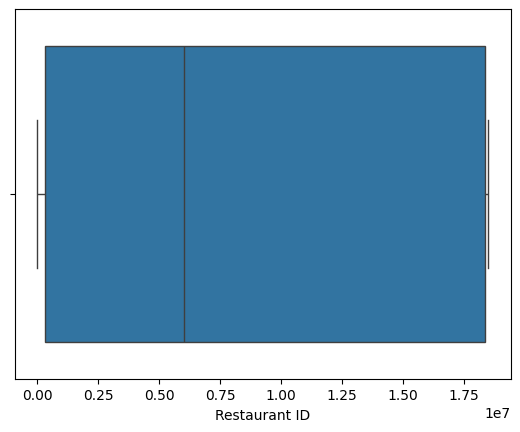

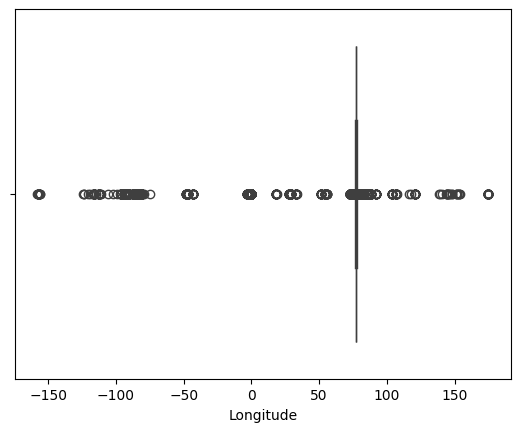

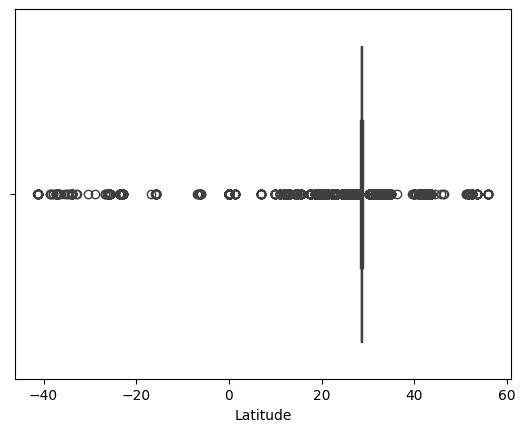

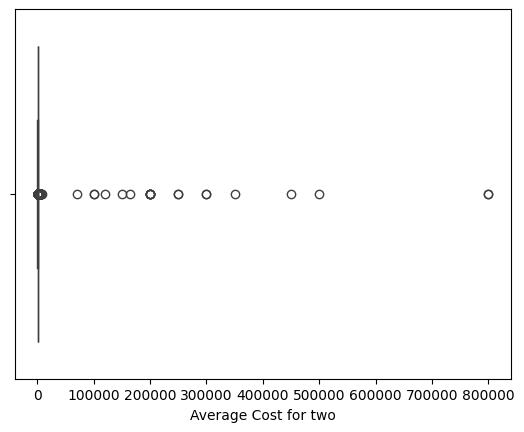

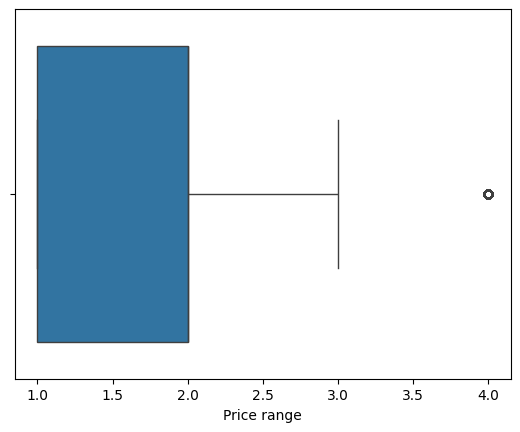

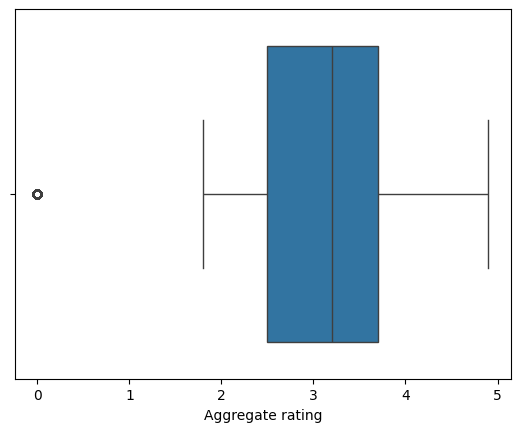

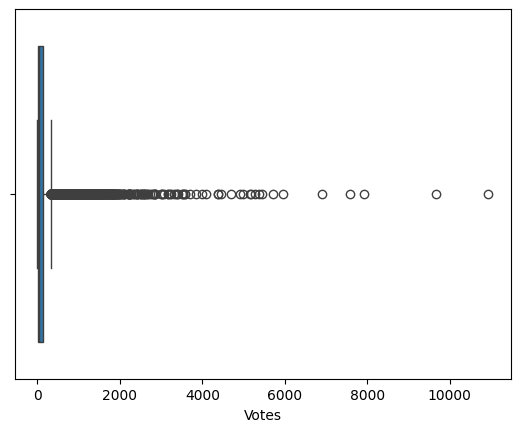

In [44]:
for i in df.select_dtypes(include = "number").columns:
  sns.boxplot(data = df, x=i)
  plt.show()

#**Train-Test Split**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Aggregate rating"]),
                                                    df["Aggregate rating"], test_size = 0.25,
                                                    random_state = 42)

In [46]:
# Define column names
#original_columns = X_train.columns

#**Data Preprocessing**

**Outlier Treatment**

In [47]:
#functions to treat Outliers
def outlier_treatment(df):
  for i in df.select_dtypes(include = "number").columns:
    q1, q3 = np.percentile(df[i],[25, 75])
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    lower_bound = q1 - (1.5 * iqr)
    df[i] = np.where(df[i] > upper_bound, upper_bound, df[i])
    df[i] = np.where(df[i] < lower_bound, lower_bound, df[i])
  return df

In [48]:
trf1 = FunctionTransformer(outlier_treatment, validate = False)

**Binary Data Encoding**

In [49]:
# Dictionary for conversion
N_Conversion = {"No": 0, "Yes": 1}

# Function to apply mapping
def convert_columns(df):
    columns_to_convert = ["Has Table booking", "Has Online delivery", "Is delivering now"]
    df[columns_to_convert] = df[columns_to_convert].applymap(lambda x: N_Conversion.get(x, x))
    return df

In [50]:
trf2 = FunctionTransformer(convert_columns, validate = False)

**Missing Value Imputation**

In [51]:
trf3 = ColumnTransformer([
    ("imputer_1", SimpleImputer(strategy = "mean"),[6]),
    ("imputer_2", SimpleImputer(strategy = "most_frequent"), [1, 5, 8, 9])
], remainder = "passthrough")

**Categorical Encoding**

In [52]:
trf4 = ColumnTransformer([
    ("oh_encoder", OneHotEncoder(sparse_output=False,handle_unknown= "ignore", drop = "first"), [1,6,2,9]),
    ("o_encoder", OrdinalEncoder(categories = [["Excellent", "Very Good", "Good", "Average",
                                                "Poor", "Not rated"]]), [12])
], remainder = "passthrough")

#Previous Columns Index - Shifted Coulum Index after previous Operations In the pipeline
0-6
1-1
2-5
3-8
4-9
5-0
6-2
7-3
8-4
9-7
10-10
11-11
12-12
13-13

0

**Feature Scaling**

In [53]:
trf5 = ColumnTransformer([
    ("scaler", StandardScaler(), slice(0,-1))
], remainder = "passthrough")

**Feature Selection**

In [54]:
trf6 = SelectKBest(score_func = f_regression, k = 10)

#**Model Training**

**Initial Model Pipeline**

In [55]:
trf7 = GradientBoostingRegressor()

In [56]:
pipe = Pipeline([
    ("trf1", trf1),
    ("trf2", trf2),
    ("trf3", trf3),
    ("trf4", trf4),
    ("trf5", trf5),
    ("trf6", trf6),
    ("trf7", trf7)
])

In [57]:
pipe

Pipeline(steps=[('trf1',
                 FunctionTransformer(func=<function outlier_treatment at 0x7b801f2c2de0>)),
                ('trf2',
                 FunctionTransformer(func=<function convert_columns at 0x7b801f2c2840>)),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_1', SimpleImputer(),
                                                  [6]),
                                                 ('imputer_2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1, 5, 8, 9])])),
                ('trf4',
                 Colum...
                                                                sparse_output=False),
                                                  [1, 6, 2, 9]),
                                                 ('o_encoder',
                                                  OrdinalEncoder(categories=[['Excellent',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Average',
                                                                              'Poor',
                                                                              'Not '
                                                                              'rated']]),
                                                  [12])])),
                ('trf5',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  slice(0, -1, None))])),
                ('trf6',
                 SelectKBest(score_func=<function f_regression at 0x7b80b653e5c0>)),
                ('trf7', GradientBoostingRegressor())])

**Cross Validation**

In [58]:
CV = cross_val_score(pipe, X_train, y_train, cv = 10, scoring = "r2" ).mean()

In [59]:
CV

0.9878671347579899

**Hyperparameter Tunning**

In [60]:
params = {
    "trf7__n_estimators": [50, 100],
    "trf7__learning_rate": [0.01, 0.1, 0.2],
    "trf7__max_depth": [3, 5, 7]
}

In [61]:
GSCV = GridSearchCV(pipe, params, cv = 10, scoring = "r2")

In [62]:
GSCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('trf1',
                                        FunctionTransformer(func=<function outlier_treatment at 0x7b801f2c2de0>)),
                                       ('trf2',
                                        FunctionTransformer(func=<function convert_columns at 0x7b801f2c2840>)),
                                       ('trf3',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer_1',
                                                                         SimpleImputer(),
                                                                         [6]),
                                                                        ('imputer_2',
                                                                         SimpleImputer(strategy='most_frequent'...
                                                                         [12])])),
                                       ('trf5',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(0, -1, None))])),
                                       ('trf6',
                                        SelectKBest(score_func=<function f_regression at 0x7b80b653e5c0>)),
                                       ('trf7', GradientBoostingRegressor())]),
             param_grid={'trf7__learning_rate': [0.01, 0.1, 0.2],
                         'trf7__max_depth': [3, 5, 7],
                         'trf7__n_estimators': [50, 100]},
             scoring='r2')

In [63]:
GSCV.best_estimator_

Pipeline(steps=[('trf1',
                 FunctionTransformer(func=<function outlier_treatment at 0x7b801f2c2de0>)),
                ('trf2',
                 FunctionTransformer(func=<function convert_columns at 0x7b801f2c2840>)),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_1', SimpleImputer(),
                                                  [6]),
                                                 ('imputer_2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1, 5, 8, 9])])),
                ('trf4',
                 Colum...
                                                  OrdinalEncoder(categories=[['Excellent',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Average',
                                                                              'Poor',
                                                                              'Not '
                                                                              'rated']]),
                                                  [12])])),
                ('trf5',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  slice(0, -1, None))])),
                ('trf6',
                 SelectKBest(score_func=<function f_regression at 0x7b80b653e5c0>)),
                ('trf7',
                 GradientBoostingRegressor(max_depth=5, n_estimators=50))])

In [64]:
GSCV.best_score_

0.9879292278038024

In [65]:
GSCV.best_params_

{'trf7__learning_rate': 0.1, 'trf7__max_depth': 5, 'trf7__n_estimators': 50}

**Final Model Training**

In [70]:
#Training the final pipeline with best parameters
trf7_m = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.1, max_depth = 5)

In [71]:
pipe_m = Pipeline([
    ("trf1", trf1),
    ("trf2", trf2),
    ("trf3", trf3),
    ("trf4", trf4),
    ("trf5", trf5),
    ("trf6", trf6),
    ("trf7", trf7_m),

])


In [72]:
pipe_m.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 FunctionTransformer(func=<function outlier_treatment at 0x7b801f2c2de0>)),
                ('trf2',
                 FunctionTransformer(func=<function convert_columns at 0x7b801f2c2840>)),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_1', SimpleImputer(),
                                                  [6]),
                                                 ('imputer_2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1, 5, 8, 9])])),
                ('trf4',
                 Colum...
                                                  OrdinalEncoder(categories=[['Excellent',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Average',
                                                                              'Poor',
                                                                              'Not '
                                                                              'rated']]),
                                                  [12])])),
                ('trf5',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  slice(0, -1, None))])),
                ('trf6',
                 SelectKBest(score_func=<function f_regression at 0x7b80b653e5c0>)),
                ('trf7',
                 GradientBoostingRegressor(max_depth=5, n_estimators=50))])

#**Model Deployment**

In [74]:
import pickle

pickle.dump(pipe_m, open("pipe_m.pkl", "wb"))
